In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [2]:
def read_and_clean(filename):
    '''
    Function takes input as filename to be cleaned. Rows that have values of nan are deleted. 
    Remaining rows are returned as an ndarray.
    '''
    data = np.genfromtxt(fname)
    data = np.delete(data, np.where(np.isnan(data))[0], axis=0)
    
    return data

<i>Using the convolve function was not an original idea - I would like to thank Stackoverflow for this.</i>

In [3]:
def smooth_data(data, width):
    '''
    This function takes the rolling/moving average of the fluxes - second column of the 'data' array
    This is done by using the numpy.convolve method. 
    '''
    return np.convolve(data[:,1], np.ones(width), 'valid')/width 

In [4]:
def find_freq(data, max_freq = 2000, n_bins = 100):
    freq_range = np.linspace(.2, max_freq, n_bins)
    power = sc.signal.lombscargle(data[:,0], data[:,1], freq_range, normalize = True)
    # plt.plot(freq_range, power)
    T_peak = 1/freq_range[np.argmax(power)] # Identifying peak of power function and returning corresponding time period

    fig_fft, ax3 = plt.subplots(1, 1, figsize=(12,5), facecolor='aliceblue')
    ax3.plot(freq_range, power)
    return T_peak, power

<i>The above function seems to produce varying results for different values of n_bins, which should not be happening.</i>

In [5]:
def eclipse(time, t_0, t_total, t_in, d, f_star):
    '''
    This is the basic model for the eclipse. The parameters can be optimized for a good fit,
    t_0 is the point in time that corresponds to the start of the eclipse.
    t_total is the commplete duration of the eclipse
    t_in is the ingress time of the eclipse (egress time is assumed to equal ingress time.
    d is the depth of the eclipse.
    '''
    
    slope = d/t_in

    temp = np.where((time<t_0) | (time > t_0 + t_total), f_star, f_star-1000)
    temp = np.where((time >= t_0) & (time < t_0 + t_in), f_star - slope*(time-t_0), temp)
    temp = np.where((time > t_0 + t_in) & (time < t_0 + t_total - t_in), f_star - d, temp)
    temp = np.where((time > t_0 + t_total - t_in) & (time < t_0 + t_total), f_star -slope*(t_0 + t_total-time), temp)

    # If t < t_0 or if t>t_0, f = f_star
    # If t > t_0 and t < t_0 + t_in, f = straight line
    # if t > t_0 + t_in and t < t_0 + t_total - t_in, f = f_star-d
    # If t > t_0 + t_total - t_in and t < t_0 + t_total, f = straight line with opp slope
    # If t > t_0 + t_total, f = f_star
    
    return temp

In [6]:
def fit_curve(data, t_0, t_total, t_in, d, f_star):
    '''
    Takes a 2d array of data corr to time and flux values, fits a model using the optimize_curve method of scipy, 
    returns the model fit.
    '''
    model = sc.optimize.curve_fit(eclipse, data[:,0], data[:,1], [t_0, t_total, t_in, d, f_star])
    
    return model[0]

Time period = 3.011449231696294 days


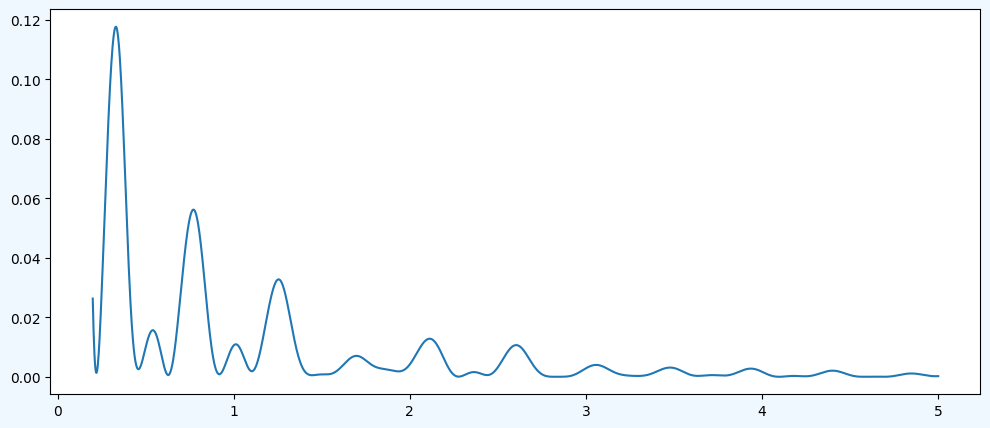

In [7]:
fname = 'Data/tess_lc1.dat'
window_length = 13  # has to be odd as you need to take the same number of values on either side of the cell
dat = read_and_clean(fname)
raw_dat = dat.copy()
# Re-writing data after smoothing with edges removed
dat[:,1][int((window_length-1)/2) : - int((window_length-1)/2)]= smooth_data(dat, window_length) 

T = find_freq(dat, 5, 2000)[0]
print(f'Time period = {T} days')

t_0 = 1328.5620498476585; t_tot  = 0.24429795723872313


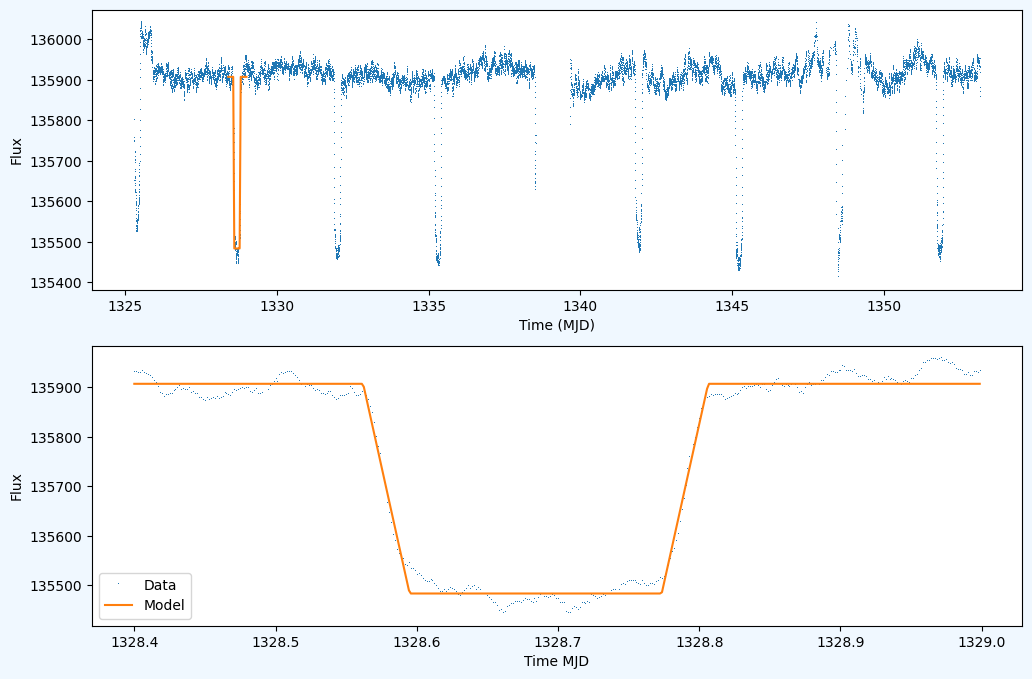

In [8]:
multiplier = 1
time_start = 1328.4
time_end = 1329

zoomed_in = dat[np.logical_and(dat[:,0] > time_start, dat[:,0] < time_end)]  # Can set the window range as variables eventually

# Plotting dataset across all time and zoomed in section

fig_timeseries, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), facecolor='aliceblue')
ax1.plot(dat[:,0], dat[:,1], ',', label='FFT')
ax2.plot(zoomed_in[:,0], zoomed_in[:,1], ',', label='Data')

# Fitting and plotting
fit_params = fit_curve(zoomed_in, t_0=time_start, t_total=0.3, t_in=0.05, d=400, f_star=135900)
print(f't_0 = {fit_params[0]}; t_tot  = {fit_params[1]}')
model = eclipse(zoomed_in[:,0], fit_params[0], fit_params[1], fit_params[2], fit_params[3], fit_params[4])

ax1.plot(zoomed_in[:,0], model, label='Model')
ax2.plot(zoomed_in[:,0], model, label='Model')

ax2.set_ylabel('Flux')
ax2.set_xlabel('Time MJD')
ax1.set_ylabel('Flux')
ax1.set_xlabel('Time (MJD)')
ax2.legend()

plt.show()

# dat[:,1][int((window_length-1)/2):-int((window_length-1)/2)] = smooth_data(dat,window_length)
# plt.plot(dat[:,0], dat[:,1], ',')
# plt.show()

# results = sc.optimize.curve_fit(eclipse, selected_data[:,0], selected_data[:,1], [1331.9, 0.2, .01, 400, 135900])
# print('results', results)
# selected_data[:,1] = eclipse(selected_data[:,0], results[-1][0], results[-1][1],results[-1][2], results[-1][3], results[-1][4])